# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instructions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Import libraries

In [61]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from lib.datasets import CIFAR10_tf

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TensorFlow Version 1.12.0


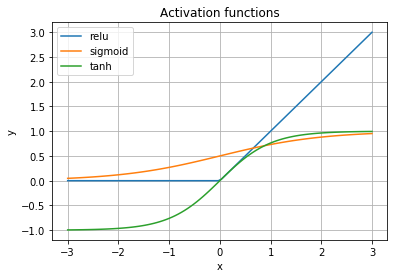

In [62]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [63]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.12.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use the standard 50,000 images for training and 10,000 images for test.

In [191]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

data = CIFAR10_tf(num_training=num_training,
                  num_validation=num_validation,
                  num_test=num_test)

# Load cifar-10 data
X_train, Y_train = data['data_train'], data['labels_train']
X_val, Y_val = data['data_val'], data['labels_val']
X_test, Y_test = data['data_test'], data['labels_test']

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [65]:
# Define max pooling and conv layers

def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: Complete the following functions                                    #
#############################################################################
def flatten(input):
    """
        - input: input tensors
    """
    output = tf.contrib.layers.flatten(input)
    return output

def fc(input, num_output):
    """
        - input: input tensors
        - num_output: int, the output dimension
    """
    # tf.contrib.layers.fully_connected has default setting where relu is activation
    # Instead use tf.layers.dense
    # output = tf.contrib.layers.fully_connected(intput, num_output)
    output = tf.layers.dense(input, units=num_output)
    return output

def norm(input, is_training):
    """
        - input: input tensors
        - is_training: boolean, if during training or not
    """
    # The same reason above
    # output = tf.contrib.layers.batch_norm(input, decay=0.9, center=True, activation_fn=tf.nn.relu,
    #                                     epsilon=1e-5, is_training=is_training)
    output = tf.layers.batch_normalization(input, training=is_training)
    return output
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional neural network

In [66]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))

        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fc(self.relu3, 10)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])

        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_training = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        # Adam optimizer
        # Learning rate:
        # Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
        # Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'
        # Loss:
        # Softmax cross entropy loss
        # Use 'tf.nn.softmax_cross_entropy_with_logits'
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(learning_rate=5e-4,
                                                   global_step=global_step,
                                                   decay_steps=500, 
                                                   decay_rate=0.96)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.loss_op, name="train_op")      
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {
                    self.X: X_,
                    self.Y: Y_,
                    self.is_training: True,
                    self.keep_prob: None
                }
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        #############################################################################
        # TODO: Plot training curve                                                 #
        #############################################################################
        # Graph 1. X: epoch, Y: training loss
        plt.subplot(2, 1, 1)
        plt.title('Training Loss with Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.plot(losses)
        
        iter2epoch = int(49000 / 128)
        plt.subplot(2, 1, 2)
        plt.title('Training Loss with Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        epoch_losses = [losses[index] for index in range(0, len(losses), iter2epoch)]
        plt.plot(epoch_losses)        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
            
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {
                self.X: X_,
                self.Y: Y_,
                self.is_training: False,
                self.keep_prob: None
            }
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 20.938, accuracy = 0.148
iteration (50): loss = 2.216, accuracy = 0.141
iteration (100): loss = 2.082, accuracy = 0.250
iteration (150): loss = 1.808, accuracy = 0.344
iteration (200): loss = 1.838, accuracy = 0.336
iteration (250): loss = 1.777, accuracy = 0.398
iteration (300): loss = 1.558, accuracy = 0.453
iteration (350): loss = 1.577, accuracy = 0.430
validation for epoch 0
-  epoch 0: validation accuracy = 0.510
train for epoch 1
iteration (400): loss = 1.423, accuracy = 0.453
iteration (450): loss = 1.457, accuracy = 0.500
iteration (500): loss = 1.361, accuracy = 0.523
iteration (550): loss = 1.244, accuracy = 0.609
iteration (600): loss = 1.342, accuracy = 0.547
iteration (650): loss = 1.438, accuracy = 0.477
iteration (700): loss = 1.197

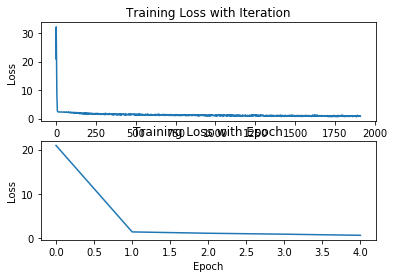

In [68]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/gpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.  
For GPU usage, simply change the following line of the training block:  
from `with tf.device('/cpu:0')` to `with tf.device('/GPU:0')`  
and you can set your desired device number  

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80%, you will get 5 extra points.

In [198]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 20
    
    ## DATA AUGMENTATION SET
    def data_augmentation(self, data, crop=False, flip=False, normalized=False):
        ret = data
        if crop and np.random.randint(2) == 0:
            ret = self._random_crop(ret)
        if flip:
            ret = self._random_flip_leftright(ret)
        if normalized:
            ret = self.normalize(ret)
        return ret
    def normalize(self, data):
        data_norm = data / 255.0
        return data_norm
    def _random_crop(self, data, crop_shape=(32, 32), padding=4):
        pad_image = np.pad(data, [[padding, padding], [padding, padding], [0, 0]], 'constant')
        left = np.random.randint(pad_image.shape[0] - crop_shape[0] + 1)
        right = np.random.randint(pad_image.shape[1] - crop_shape[1] + 1)
        ret = pad_image[left: left + crop_shape[0], right: right + crop_shape[1], :]
        return ret    
    def _random_flip_leftright(self, data):
        if np.random.randint(2) == 0:
            ret = np.fliplr(data)
        else:
            ret = data
        return ret
    
    # OPTIMIZER SET ESPECIALLY FOR LR DECAY
    def _build_optimizer(self):
        global_step = tf.Variable(0, trainable=False)
        learning_rate = tf.train.exponential_decay(learning_rate=1e-4,
                                                   global_step=global_step,
                                                   decay_steps=300, 
                                                   decay_rate=0.96)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.loss_op, name="train_op")      
    
    # MODEL STRUCTURE
    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            # self.norm1 = norm(self.conv1, is_training=self.is_training)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            # self.norm2 = norm(self.conv2, is_training=self.is_training)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            print('conv2 layer: ' + str(self.pool2.get_shape()))
            
        with tf.variable_scope('conv3'):
            self.conv3 = conv2d(self.pool2, 3, 1, 384)
            # self.norm3 = norm(self.conv3, is_training=self.is_training)
            self.relu3 = tf.nn.relu(self.conv3)
            self.pool3 = max_pool(self.relu3, 3, 2)
            print('conv2 layer: ' + str(self.pool3.get_shape()))

        self.flat = flatten(self.pool3)      
        print('flat layer: ' + str(self.flat.get_shape()))
        
        with tf.variable_scope('fc3'):
            self.fc3 = fc(self.flat, 384)
            self.dropout3 = tf.layers.dropout(self.fc3, training=self.is_training, rate=(1-self.keep_prob))
            self.relu3 = tf.nn.relu(self.dropout3)
            print('fc3 layer: ' + str(self.relu3.get_shape()))
            
        with tf.variable_scope('fc4'):
            self.fc4 = fc(self.relu3, 10)
            print('fc4 layer: ' + str(self.fc4.get_shape()))
            
        # Return the last layer
        return self.fc4
        
    # EXECUTE DATA AUGMENTATION BEFORE TRAINING
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        
        # preprocess and data_augmentation
        for index in range(X_train.shape[0]):
            X_train[index] = self.data_augmentation(data=X_train[index], normalized=False, crop=False, flip=False)
        
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                feed_dict = {
                    self.X: X_,
                    self.Y: Y_,
                    self.is_training: True,
                    self.keep_prob: 0.75
                }
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
        # Graph 1. X: epoch, Y: training loss
        plt.subplot(2, 1, 1)
        plt.title('Training Loss with Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.plot(losses)
        
        iter2epoch = int(49000 / 128)
        plt.subplot(2, 1, 2)
        plt.title('Training Loss with Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        epoch_losses = [losses[index] for index in range(0, len(losses), iter2epoch)]
        plt.plot(epoch_losses)        
        
    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]

            feed_dict = {
                self.X: X_,
                self.Y: Y_,
                self.is_training: False,
                self.keep_prob: 1
            }

            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv2 layer: (?, 4, 4, 384)
flat layer: (?, 6144)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 10.073, accuracy = 0.062
iteration (50): loss = 1.884, accuracy = 0.344
iteration (100): loss = 1.622, accuracy = 0.414
iteration (150): loss = 1.667, accuracy = 0.359
iteration (200): loss = 1.625, accuracy = 0.398
iteration (250): loss = 1.659, accuracy = 0.453
iteration (300): loss = 1.378, accuracy = 0.547
iteration (350): loss = 1.477, accuracy = 0.492
validation for epoch 0
-  epoch 0: validation accuracy = 0.546
train for epoch 1
iteration (400): loss = 1.415, accuracy = 0.477
iteration (450): loss = 1.366, accuracy = 0.547
iteration (500): loss = 1.391, accuracy = 0.500
iteration (550): loss = 1.238, accuracy = 0.586
iteration (600): loss = 1.318, accuracy = 0.508
iteration (650): loss = 1.322, accuracy = 0.516
i

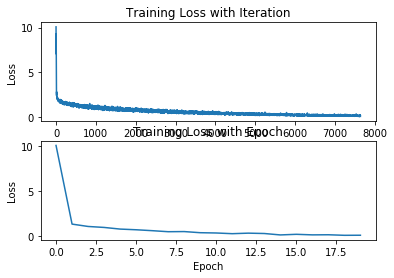

In [199]:
# Clear old computation graphs
tf.reset_default_graph()

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
    with tf.device('/gpu:0'):
        model = YourModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        # Save your model
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
        print("Model saved in %s" % model_path)

In [200]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
conv2 layer: (?, 4, 4, 384)
flat layer: (?, 6144)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
